## Лабораторная работа 4. Подбор параметров. Композиция и сравнение моделей.

Постарайтесь оформить всю работу как один монолитный рассказ/отчет. Избегайте дублирования кода. Избегайте использования циклов, вместо этого ищите готовый алгоритм в пакетах. Подписывайте все графики, а также их оси, если график содержит несколько кривых, то обязательно пользуйтесь легендой. Также неукоснительно соблюдайте PEP8. За несоблюдение этих простейших правил итоговые баллы могут быть снижены безапелляционно.

In [1]:
import warnings
warnings.simplefilter("ignore")

### 1. (15 баллов) Подбор параметров 

![](https://4.bp.blogspot.com/-t6ZSm65y1sA/WN3wC24EEcI/AAAAAAAAWhI/OHjVavGAWC8BbiEwmr8qF9c9fvQFDFe7ACLcB/s1600/3849_3.PNG)

В этом и следующих заданиях вы будете работать с данными из из репозитория UCI. Датасет называется [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult). На этом датасете вы будете решать задачу бинарной классификации, нужно определить превысит ли средний заработок человека порог в $50k.

**1. (1 балл)** Загрузите набор данных `data_adult.csv`. Учтите, что пропущенные значения признаков в данных помечены как `'?'`. Проведите предобработку данных:

 - Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.
 - Сохраните целевую переменную (ту, которую мы хотим предсказывать) в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными (числовыми). В начале мы будем работать только с вещественными признаками. Сохраните их отдельно.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("./data/data_adult.csv", sep=",", na_values="?")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [4]:
y = df[">50K,<=50K"].str.get_dummies()[">50K"].values

In [5]:
real_cols = ["fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
X = df[real_cols].values

**2. (2 балла)** В начале посмотрим как работает подбор гиперпараметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 4 алгоритма:
 - [KNeighborClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - KNeighborClassifier — число соседей (*n_neighbors*)
 - DecisonTreeClassifier — глубина дерева (*max_depth*)
 - SGDClassifier — оптимизируемая функция (*loss*)
 
Значения остальных гиперпараметров оставляйте по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). В качестве схемы кросс-валидации используйте 5-Fold CV, которую можно задать с помощью класса [KFoldCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold).

![](https://i.stack.imgur.com/YWgro.gif)

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал. 

Для получения значения качества на каждом фолде, среднего значение качества и другой полезной информации можно воспользоваться полем [*cv results_*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

У какого алгоритма наибольшее среднее значение качества? Наибольший доверительный интервал?

In [6]:
# это нужно для перебора
from sklearn.model_selection import GridSearchCV, KFold
# это нужно для моделей
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

<font color="#884EA0">Заведём отдельные функции, чтобы не перепечатывать каждый раз много кода:</font>

In [8]:
def train_model(model_proto, model_params, X, y):
    model = GridSearchCV(
        estimator=model_proto,
        param_grid=model_params,
        scoring="roc_auc",
        cv=KFold(n_splits=5),
        verbose=1,
        n_jobs=-1
    )
    model.fit(X, y)
    return model

In [9]:
def plot_model(model, x_params):
    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    plt.plot(x_params, means, label="ROC-AUC")
    plt.fill_between(x_params, means + stds, means - stds, alpha = 0.2, label="дов. интервал")
    print("Лучшее значение гиперпараметра: ", model.best_params_) 
    print("Среднее качество: {:.5f}".format(model.best_score_))
    print("Наибольший доверительный интервал: {:.5f}".format(float(max(model.cv_results_["std_test_score"]))))

In [60]:
def plot_wrapper(model, x_params, axis):
    plt.figure(figsize=(18, 8))
    plt.grid()
    # заголовок
    plt.title("ROC-AUC для модели {}".format(axis["title"]), fontsize=16)
    # ось X
    # plt.xlim(0, len(x_params))
    plt.xticks(axis["x"], fontsize=12)
    plt.xlabel("Значение {}".format(axis["x_title"]), fontsize=14)
    # ось Y
    plt.ylabel("Значение метрики ROC-AUC", fontsize=14)
    # графики
    plot_model(model, x_params)
    # общие штуки
    plt.legend(loc="best");

<font color="#884EA0">k Nearest Neighbors:</font>

In [11]:
x_knn = np.arange(1, 100, 2)
params_knn = {"n_neighbors": x_knn}
knn = train_model(KNeighborsClassifier(), params_knn, X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   49.5s finished


Лучшее значение гиперпараметра:  {'n_neighbors': 5}
Среднее качество: 0.64161
Наибольший доверительный интервал: 0.01348


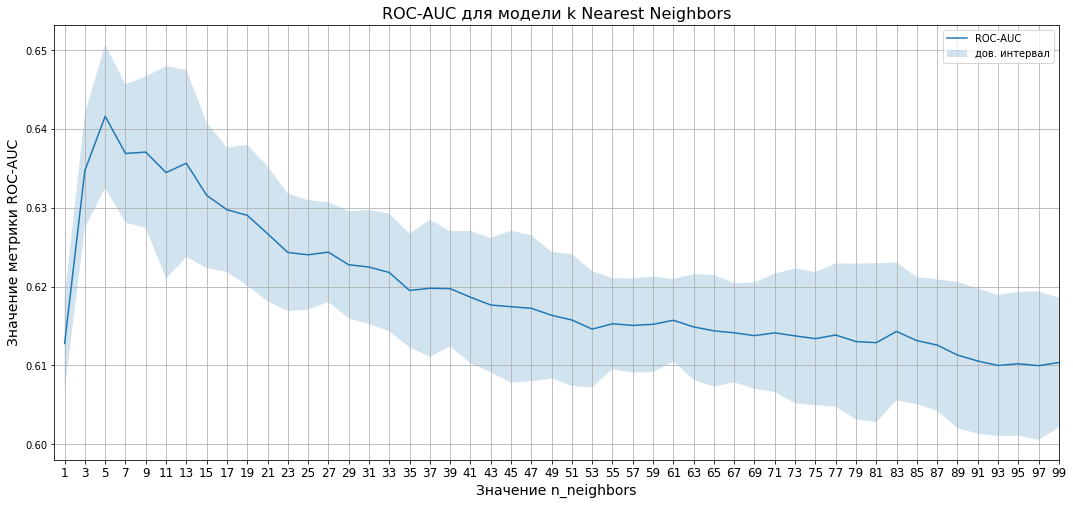

In [12]:
axis_knn = {
    "title": "k Nearest Neighbors",
    "x_title": "n_neighbors",
    "x": np.arange(1, max(x_knn)+1, 2)
}
plot_wrapper(knn, x_knn, axis_knn)

<font color="#884EA0">Decision Tree:</font>

In [13]:
x_tree = np.arange(1, 100)
params_tree = {"max_depth": x_tree}
tree = train_model(DecisionTreeClassifier(), params_tree, X, y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 488 out of 495 | elapsed:   13.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   13.6s finished


Лучшее значение гиперпараметра:  {'max_depth': 6}
Среднее качество: 0.81295
Наибольший доверительный интервал: 0.01399


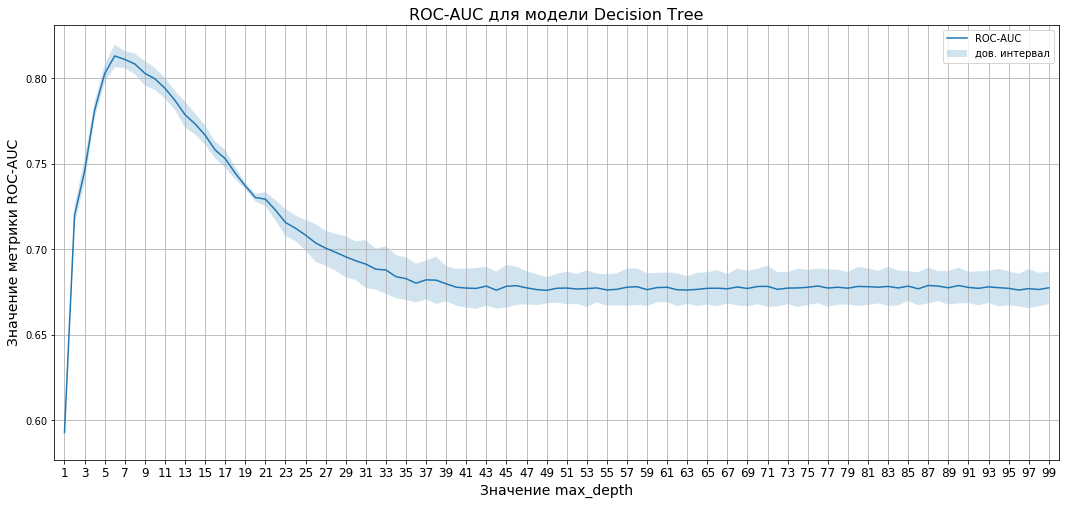

In [14]:
axis_tree = {
    "title": "Decision Tree",
    "x_title": "max_depth",
    "x": np.arange(1, max(x_tree)+1, 2)
}
plot_wrapper(tree, x_tree, axis_tree)

<font color="#884EA0">Stochastic Gradient Descent:</font>

In [15]:
params_sgd = {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", 
                       "squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]}
x_sgd = np.arange(1, len(params_sgd["loss"])+1)
sgd = train_model(SGDClassifier(), params_sgd, X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.5s finished


Лучшее значение гиперпараметра:  {'loss': 'hinge'}
Среднее качество: 0.60650
Наибольший доверительный интервал: 0.05299


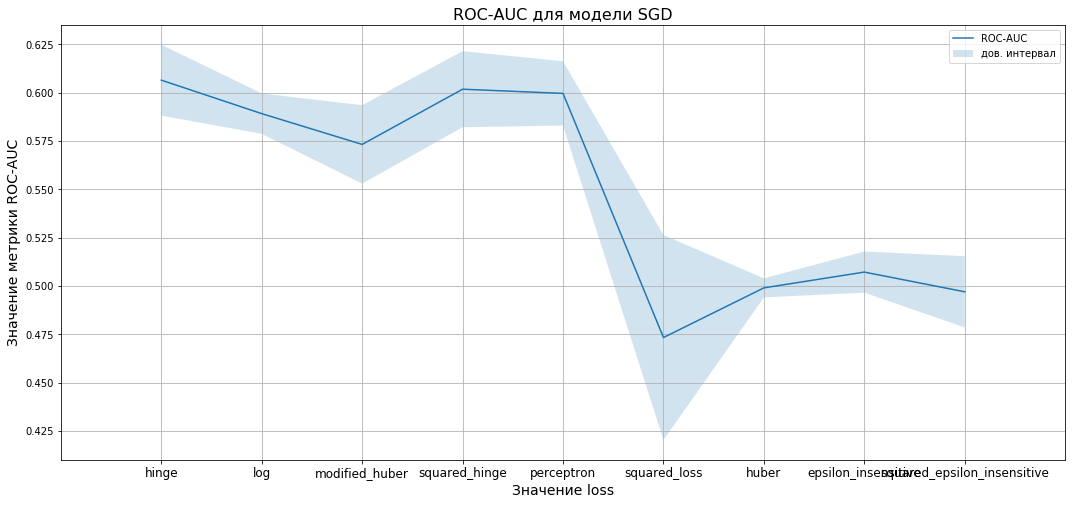

In [16]:
axis_sgd = {
    "title": "SGD",
    "x_title": "loss",
    "x": np.arange(1, len(params_sgd["loss"])+1, 1)
}
plot_wrapper(sgd, x_sgd, axis_sgd)
plt.xticks(axis_sgd["x"], params_sgd["loss"]);

<font color="#884EA0">Видим, что:
<ul>
    <li>лучшее качество даёт Decision Tree с max_depth=6,</li>
    <li>наибольший доверительный интервал — у SGDClassifier</li>
</ul>
</font>

**3. (2 балла)** Теперь подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев: обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте найденное количество деревьев.

Применить класс *GridSearchCV* в данном задании затруднительно, поэтому предлагается самостоятельно написать цикл по числу деревьев или воспользоваться параметром `warm_start=True` ([stackoverflow](https://stackoverflow.com/questions/31808821/python-random-forest-iteratively-adding-trees)).

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
params_forest = {"n_estimators": np.arange(1, 50)}
forest = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1968, warm_start=True),
    param_grid=params_forest,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
forest.fit(X, y);

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:   57.6s finished


Лучшее значение гиперпараметра:  {'n_estimators': 2}
Среднее качество: 0.78415
Наибольший доверительный интервал: 0.00632


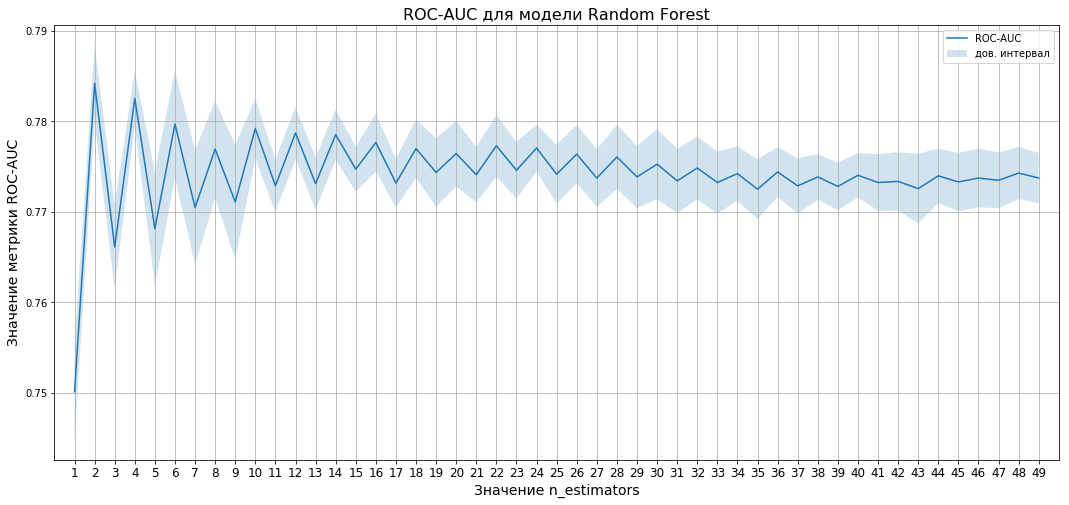

In [19]:
axis_forest = {
    "title": "Random Forest",
    "x_title": "n_estimators",
    "x": params_forest["n_estimators"]
}
plot_wrapper(forest, params_forest["n_estimators"], axis_forest)

<font color="#884EA0">Видим, что, начиная с n_estimators=40, качество более или менее стабилизируется.</font>

** 4. (2 балла)** Посмотрите на значения признаков *age*, *fnlwgt*, *capital-gain*. В чем заключается особенность данных? На какие из рассматриваемых алгоритмов это может повлиять? Может ли масштабирование повлиять на работу этих алгоритмов?

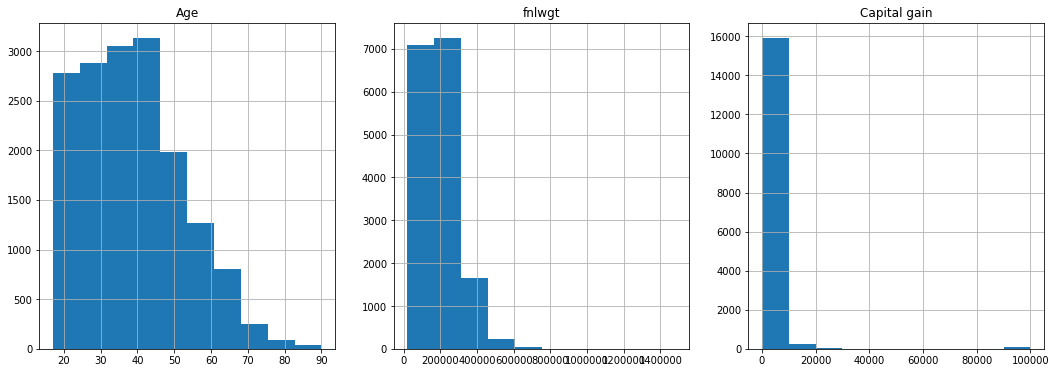

In [20]:
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1) 
plt.title("Age")
df["age"].hist()
plt.subplot(1, 3, 2) 
plt.title("fnlwgt")
df["fnlwgt"].hist()
plt.subplot(1, 3, 3) 
plt.title("Capital gain")
df["capital-gain"].hist();

<font color="#884EA0">Все эти признаки очень "смещены" в ту или иную сторону. Это может повлиять на алгоритм kNN, который будет иметь много данных в одной стороне и совсем мало — в другой. Масштабирование должно улучшить качество работы kNN.</font>

** 5. (2 балла)** Отмасштабируйте все вещественные признаки одним из указанных выше способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

Изменилось ли качество некоторых алгоритмов и почему?

<font color="#884EA0">Масштабируем данные:</font>

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
X_scaled = MinMaxScaler().fit_transform(X)

<font color="#884EA0">k Nearest Neighbors:</font>

In [23]:
x_knn = np.arange(1, 100, 2)
params_knn = {"n_neighbors": x_knn}
knn = train_model(KNeighborsClassifier(), params_knn, X_scaled, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.3min finished


Лучшее значение гиперпараметра:  {'n_neighbors': 95}
Среднее качество: 0.79397
Наибольший доверительный интервал: 0.01002


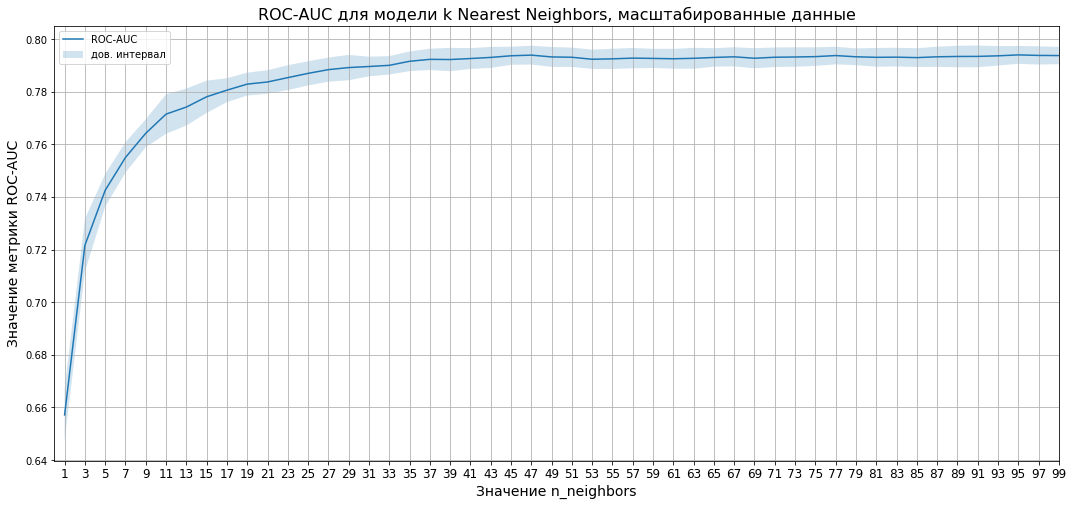

In [24]:
axis_knn = {
    "title": "k Nearest Neighbors, масштабированные данные",
    "x_title": "n_neighbors",
    "x": np.arange(1, max(x_knn)+1, 2)
}
plot_wrapper(knn, x_knn, axis_knn)

<font color="#884EA0">Decision Tree:</font>

In [25]:
x_tree = np.arange(1, 100)
params_tree = {"max_depth": x_tree}
tree = train_model(DecisionTreeClassifier(), params_tree, X_scaled, y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   12.4s finished


Лучшее значение гиперпараметра:  {'max_depth': 6}
Среднее качество: 0.81295
Наибольший доверительный интервал: 0.01368


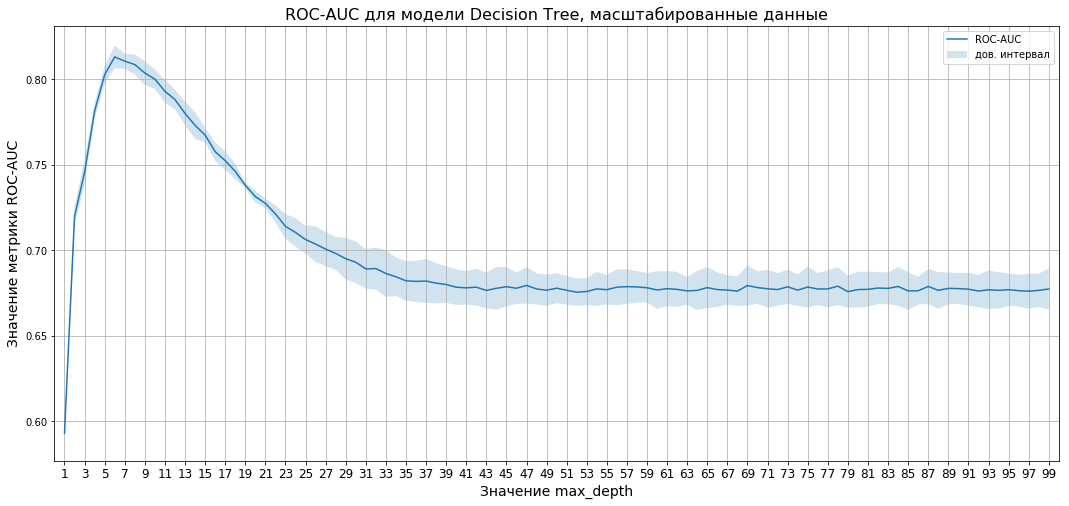

In [26]:
axis_tree = {
    "title": "Decision Tree, масштабированные данные",
    "x_title": "max_depth",
    "x": np.arange(1, max(x_tree)+1, 2)
}
plot_wrapper(tree, x_tree, axis_tree)

<font color="#884EA0">Stochastic Gradient Descent:</font>

In [27]:
params_sgd = {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", 
                       "squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]}
x_sgd = np.arange(1, len(params_sgd["loss"])+1)
sgd = train_model(SGDClassifier(), params_sgd, X_scaled, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.5s finished


Лучшее значение гиперпараметра:  {'loss': 'modified_huber'}
Среднее качество: 0.79932
Наибольший доверительный интервал: 0.01102


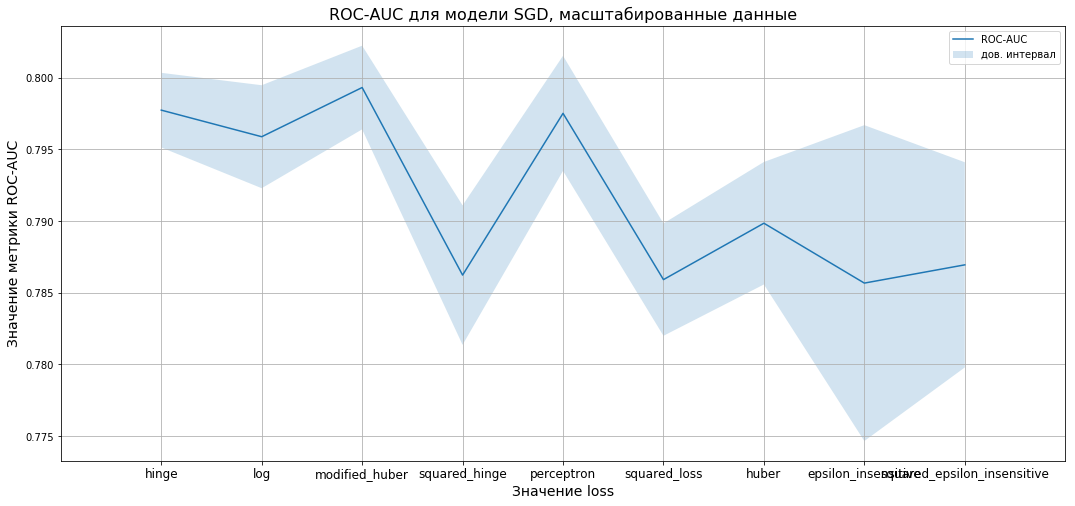

In [28]:
axis_sgd = {
    "title": "SGD, масштабированные данные",
    "x_title": "loss",
    "x": np.arange(1, len(params_sgd["loss"])+1, 1)
}
plot_wrapper(sgd, x_sgd, axis_sgd)
plt.xticks(axis_sgd["x"], params_sgd["loss"]);

<font color="#884EA0">
Сравним получившиеся ROC-AUC:
<ul>
    <li><b>kNN:</b> до=0.6461, после=0.73937</li>
    <li><b>Decision Tree:</b> до=0.81295, после=0.81295</li>
    <li><b>kNN:</b> до=0.60818, после=0.79850</li>
</ul>

Как видно, качество работы алгоритмов улучшилось, так как мы "адаптировали" данные под них (например, масштабирование улучшило работу kNN, как мы и предполагали).
</font>

** 6. (2 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и максимальное число рассматриваемых признаков (*max_features*); используйте найденное ранее каличество деревьев
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели".

Какой из алгоритмов имеет наилучшее качество? 

<font color="#884EA0">k Nearest Neighbors:</font>

In [29]:
params_knn = {
    "n_neighbors": np.arange(1, 100, 2), 
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
}
knn = train_model(KNeighborsClassifier(), params_knn, X_scaled, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.7min finished


In [30]:
print("Best parameters: {}".format(knn.best_params_))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 75}


<font color="#884EA0">Decision Tree:</font>

In [31]:
params_tree = {
    "max_depth": np.arange(1, 100),
    "criterion": ["gini", "entropy"]
}
tree = train_model(DecisionTreeClassifier(), params_tree, X_scaled, y)
print("Best parameters: {}".format(tree.best_params_))

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   18.4s


Best parameters: {'criterion': 'gini', 'max_depth': 6}


[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   27.8s finished


<font color="#884EA0">Stochastic Gradient Descent:</font>

In [32]:
params_sgd = {
    "loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", 
                       "squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
    "penalty": ["l2", "l1", "elasticnet"]
}
sgd = train_model(SGDClassifier(), params_sgd, X_scaled, y)
print("Best parameters: {}".format(sgd.best_params_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done 128 out of 135 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.4s finished


Best parameters: {'loss': 'log', 'penalty': 'l1'}


<font color="#884EA0">Random Forest:</font>

In [33]:
params_forest = {
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt", "log2", None]
}
forest = train_model(RandomForestClassifier(n_estimators=40), params_forest, X_scaled, y)
print("Best parameters: {}".format(forest.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   20.0s finished


Best parameters: {'criterion': 'gini', 'max_features': None}


**7. (2 балла)** Постройте для разных алгоритмов графики [кривых обучения](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html), изображающие зависимость качества на тестовой и обучающей выборках от количества объектов, на которых обучаются модели. Посмотрите на поведение кривых и ответьте на вопросы:
* Может ли с ростом числа объектов убывать качество на тестовой выборке? А на обучающей? Почему?
* Для каких целей можно использовать знание качества на обучающей части выборки?
* Какой из алгоритмов лучше обучается на меньшем числе объектов?
* Может ли добавление новых объектов значительно повысить качество какого-то из алгоритмов или при существующем наборе данных для всех алгоритмов произошло насыщение?

In [34]:
from sklearn.model_selection import learning_curve

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(18, 8))
    plt.title(title, fontsize=16)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Количество экземпляров в обучающей выборке", fontsize=14)
    plt.ylabel("Значение метрики ROC-AUC", fontsize=14)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Значение на обучающей выборке")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Значение на кросс-валидации")

    plt.legend(loc="best")
    plt.show()

In [36]:
knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 75}

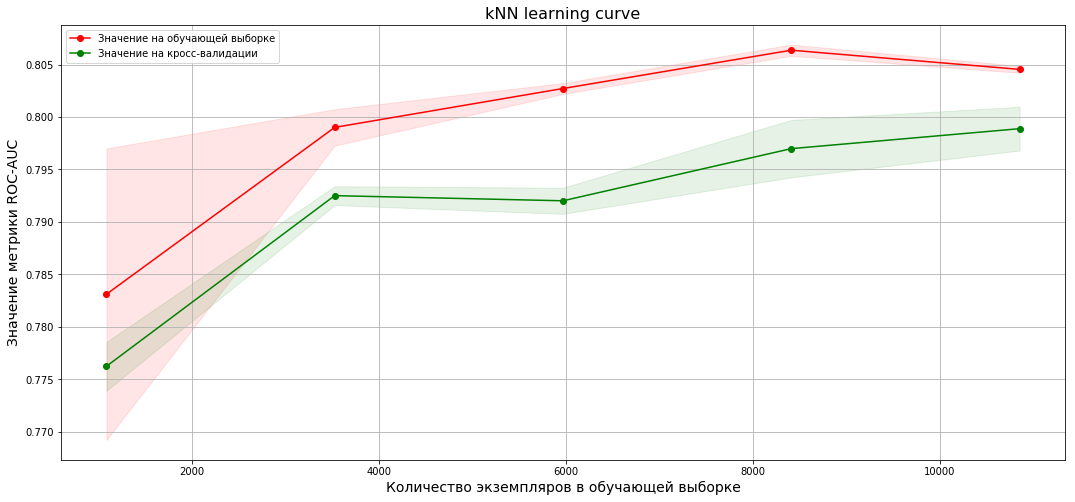

In [37]:
best_knn = KNeighborsClassifier(metric="manhattan", n_neighbors=75)
plot_learning_curve(best_knn, "kNN learning curve", X_scaled, y)

In [38]:
tree.best_params_

{'criterion': 'gini', 'max_depth': 6}

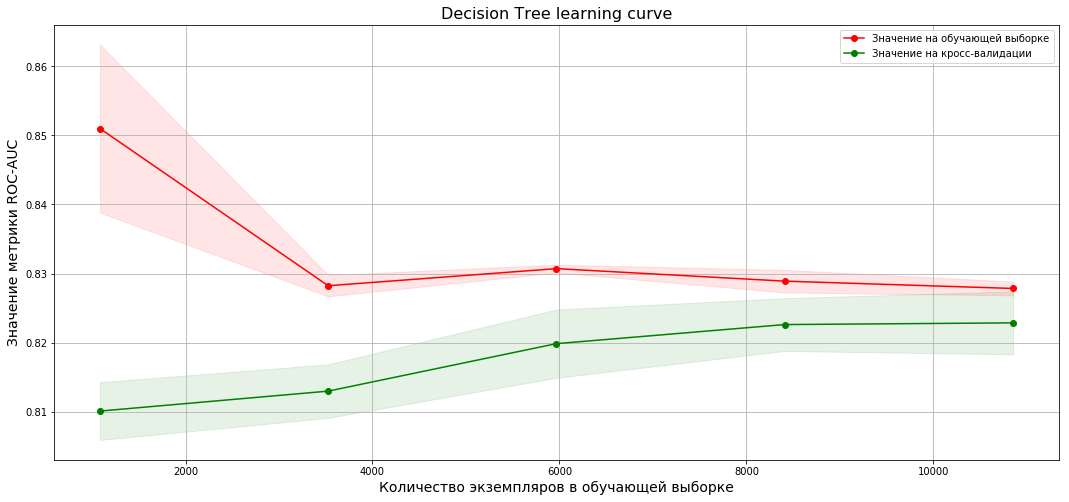

In [39]:
best_tree = DecisionTreeClassifier(max_depth=6, criterion="gini")
plot_learning_curve(best_tree, "Decision Tree learning curve", X_scaled, y)

In [40]:
sgd.best_params_

{'loss': 'log', 'penalty': 'l1'}

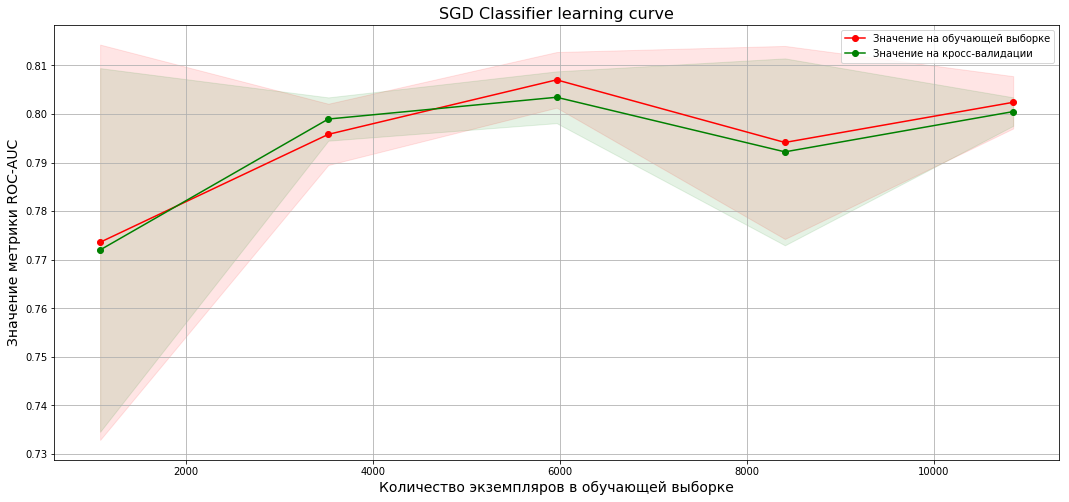

In [41]:
best_sgd = SGDClassifier(loss="log", penalty="l1")
plot_learning_curve(best_sgd, "SGD Classifier learning curve", X_scaled, y)

In [42]:
forest.best_params_

{'criterion': 'gini', 'max_features': None}

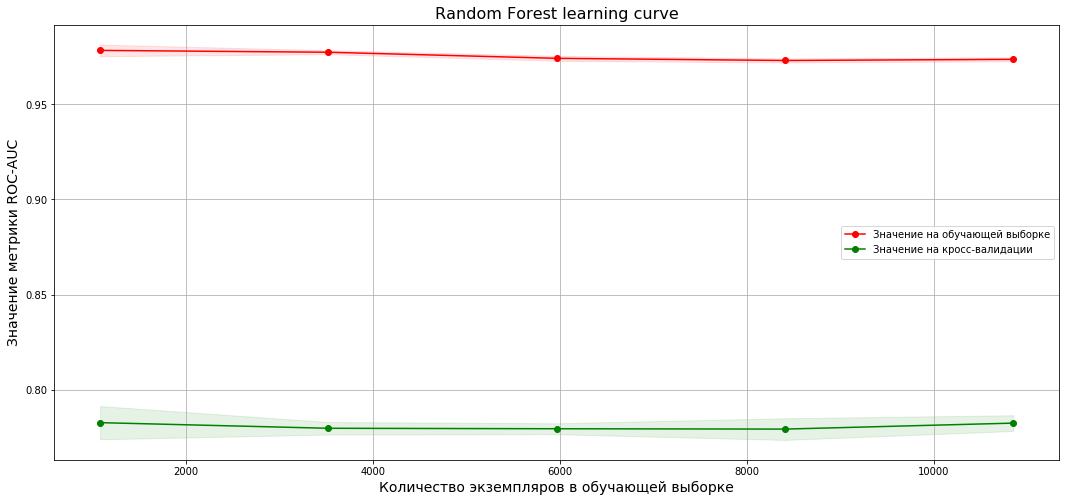

In [43]:
best_forest = RandomForestClassifier(criterion="entropy", max_features=None)
plot_learning_curve(best_forest, "Random Forest learning curve", X_scaled, y)

<font color="#884EA0">
    <p><b>Может ли с ростом числа объектов убывать качество на тестовой выборке? А на обучающей? Почему?</b><br />
        Да; например, качество kNN убывает на тестовой выборке, а Decision Tree — на обучающей. Возможно, это происходит, потому что модель может переобучиться. 
    </p>
    <p><b>Для каких целей можно использовать знание качества на обучающей части выборки?</b><br />
        Например, чтобы отследить моменты, когда качество стабилизируется.
    </p>
    <p><b>Какой из алгоритмов лучше обучается на меньшем числе объектов?</b><br />
        Random Forest.
    </p>
    <p><b>Может ли добавление новых объектов значительно повысить качество какого-то из алгоритмов или при существующем наборе данных для всех алгоритмов произошло насыщение?</b><br />
        Графики для k Nearest Neighbors и Decision Tree показывают, что для большого количества объектов качество падает; возможно, добавление новых объектов поможет исправить ситуацию.
    </p>
</font>

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**8. (1 балл)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

In [44]:
cat_cols = columns=["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex"]
df_cat = pd.get_dummies(df[cat_cols])
df_cat.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем подбирать заново оптимальные гиперпараметры для моделей с учетом новых признаков (хотя правильнее было бы это сделать). 

**9. (1 балл)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами, найденными ранее. Дало ли добавление новых признаков прирост качества? Измеряйте качество, как и раньше, используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score).

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

In [45]:
from scipy import hstack

In [46]:
X_cat = df_cat.values
X_full = hstack((X_scaled, X_cat))

In [47]:
from sklearn.model_selection import cross_val_score

In [48]:
best_models = {
    "kNN": best_knn,
    "Decision Tree": best_tree,
    "SGD Classifier": best_sgd,
    "Random Forest": best_forest
}
for model_type in best_models:
    print("Обучаю модель: {}".format(model_type))
    model_proto = best_models[model_type]
    cv_score_old = np.mean(cross_val_score(model_proto, X_scaled, y, cv=KFold(n_splits=5), scoring="roc_auc"))
    cv_score_new = np.mean(cross_val_score(model_proto, X_full, y, cv=KFold(n_splits=5), scoring="roc_auc"))
    print("\tбыло: {:.5f}\n\tстало: {:.5f}".format(cv_score_old, cv_score_new))

Обучаю модель: kNN
	было: 0.79415
	стало: 0.87925
Обучаю модель: Decision Tree
	было: 0.81294
	стало: 0.88588
Обучаю модель: SGD Classifier
	было: 0.80051
	стало: 0.89948
Обучаю модель: Random Forest
	было: 0.74767
	стало: 0.86616


<font color="#884EA0">
    Качество значительно улучшилось (особенно для kNN и Random Forest).
</font>

### 2. (5 баллов) Композиция моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания разных моделей. Давайте посмотрим, действительно ли такой подход дает прирост в качестве.

Выберете из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha\in [0, 1]$ — гиперпараметр нового классификатора.

**1. (3 балла)**
При реализации своих моделей хорошей практикой является создание sklearn-совместимых классов. Во-первых, такая реализация будет иметь стандартный интерфейс и позволит другим людям безболезненно обучать реализованные вами модели. Во-вторых, появляется возможность использовать любой функционал пакета sklearn, принимающий на вход модель, например, класс *GridSearchCV*, *learning_curve* и другие.

Создайте классификатор, который инициализируется двумя произвольными классификаторами и параметром $\alpha$. Во время обучения такой классификатор должен обучать обе базовые модели, а на этапе предсказания замешивать предсказания базовых моделей по формуле, указанной выше. 

Для создания пользовательского классификатора необходимо отнаследоваться от базовых классов *[BaseEstimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html), [ClassifierMixin](http://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html)* и реализовать методы *\_\_init\_\_, fit, predict и predict_proba*. Пример sklearn-совместимого классификатора с комментариями можно найти [здесь](http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator)

In [49]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

In [53]:
class BlendedClassifier(BaseEstimator, ClassifierMixin):
     
    def __init__(self, clf1, clf2, alpha=None):
        self.clf1 = clf1
        self.clf2 = clf2
        self.alpha = alpha
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        # Fit both classifiers and save them
        self.clf1 = self.clf1.fit(X, y)
        self.clf2 = self.clf2.fit(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        # Input validation
        X = check_array(X)
        y_ = np.around(self.alpha*self.clf1.predict(X) + (1-self.alpha)*self.clf2.predict(X), 0)
        return y_
    
    def predict_proba(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        # Input validation
        X = check_array(X)
        y_ = self.alpha*self.clf1.predict_proba(X) + (1-self.alpha)*self.clf2.predict_proba(X)
        return self.y_

**2. (2 балла)** Подберите по сетке от 0 до 1 значение $\alpha$ для этого классификатора. Если класс реализован правильно, то вы cможете использовать *GridSearchCV*, как в случае с обычными классификаторами.

Изобразите на графике среднее качество по фолдам и доверительный интервал в зависимости от $\alpha$.

In [54]:
blended = GridSearchCV(
    estimator = BlendedClassifier(clf1=best_sgd, clf2=best_tree),
    param_grid = {"alpha": np.arange(0, 1, 0.1)},
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)
blended.fit(X_full, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=BlendedClassifier(alpha=None,
         clf1=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, ran...       min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [55]:
axis_sgd

{'title': 'SGD, масштабированные данные',
 'x_title': 'loss',
 'x': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}

Лучшее значение гиперпараметра:  {'alpha': 0.5}
Среднее качество: 0.85295
Наибольший доверительный интервал: 0.01466


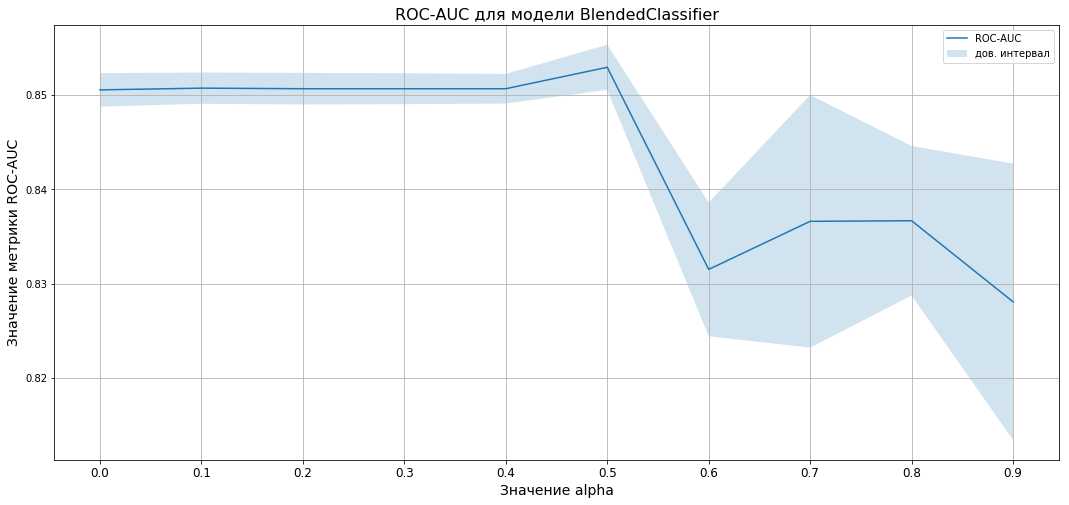

In [61]:
x_blended = np.arange(0, 1, 0.1)
axis_blended = {
    "title": "BlendedClassifier",
    "x_title": "alpha",
    "x": x_blended
}
plot_wrapper(blended, x_blended, axis_blended)

<font color="#884EA0">
    <p><b>Дал ли этот подход прирост к качеству по сравнению с моделями, обученными по отдельности?</b><br />
        Не очень, но и не сделал сильно хуже. 
    </p>
    <p><b> Поясните, почему даже простой блендинг моделей может влять на итоговое качество?</b><br />
       Потому что одна модель может хорошо "ловить" один класс, а другая — "другой", или они могут принимать во внимание разные фичи.
    </p>
</font>

### 3. (5 баллов) Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей правильным продолжением является сравнение их между собой. На семинаре по визуализации вам было показано как строить "ящик с усами" (диаграмму размаха). Воспользуемся ей для сравнения алгоритмов между собой. 

**1. (5 баллов)** Для каждого типа классификатора (KNeighborClassifier, DecisionTreeClassifier, RandomForestClassifier, SGDClassifier), а так же смешанной модели, выберете тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха. Все классификаторы должны быть изображены на одном графике.
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

### 4. (15 баллов) Бонусное задание

**1. (5 баллов)** Продолжим работать с датасетом `data.adult.csv`. Сделайте двухуровневый [стекинг моделей](https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/).
На нулевом уровне (в качестве базовых классификаторов) используйте пять лучших ранее полученных моделей. На первом уровне (в качестве метаклассификатора) используйте логистическую регрессию (LogisticRegressionCV), у которой подберите по сетке параметры `penalty` и `C` на метапризнаках. Для стекинга используйте библиотеку [brew](https://pypi.python.org/pypi/brew/0.1.4) или сделайте свою собственную реализацию классического стекинга.
Постройте `barplot`, на котором изобразите метрику качества каждой базовой модели нулевого уровня и самого метаклассификатора.

**2. (5 баллов)** Предложите алгоритм оптимального бинарного решающего дерева для задачи регресси на $l$ объектах в $n$-мерном пространстве с асимптотической сложностью $O(nl\log l)$. В качестве предикатов нужно рассматривать пороговые правила (наиболее распространенный случай для использования на практике). Для простоты можно считать, что получающееся дерево близко у сбалансированному и в качестве ошибки используется MSE:
$$
Q = \frac{1}{l}\sum_{i=1}^{l}(y_i - \tilde y_i)^2
$$

Под оптимальностью в данной задаче подразумевается, что в каждом узле дерева делается оптимальное с точки зрения MSE разбиение на два поддерева.

**3. (2+3 баллов)** Пусть имеется построенное решающее дерево для задачи многоклассовой классификации. Рассмотрим лист дерева с номером $m$ и объекты $R_m$ , попавшие в него. Обозначим за $p_{mk}$ долю объектов
$k$-го класса в листе $m$. Индексом Джини этого листа называется величина
$$
\sum_{k=1}^K p_{mk}(1 − p_{mk} ),
$$
где $K$ — общее количество классов. Индекс Джини обычно служит мерой того, насколько хорошо
в данном листе выделен какой-то один класс (так называемая [impurity function](https://onlinecourses.science.psu.edu/stat857/node/52)).
1. Поставим в соответствие листу $m$ алгоритм классификации $a(x)$, который предсказывает класс
случайно, причем класс $k$ выбирается с вероятностью $p_{mk}$ . Покажите, что матожидание ча-
стоты ошибок этого алгоритма на объектах из R m равно индексу Джини.
2. Дисперсией класса k назовем дисперсию выборки $\{[y_i = k] : x_i \in R_m\}$, где $y_i$ — класс объекта $x_i$ , $[f ]$ — индикатор истинности выражения $f$, равный 1 если $f$ верно, и нулю в противном
случае, а $R_m$ — множество объектов в листе. Покажите, что сумма дисперсий всех классов в
заданном листе равна его индексу Джини.